# Merge subclustering results in Set 2

In [1]:
# loading packages
library(Seurat)
library(ggplot2)
library(magrittr)
library(data.table)
library(Matrix)
library(dplyr)
library(tibble)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#loading data before subclustering
seu_HQC <- readRDS(file = '../../data/seurat_object/Set2/seu_HQC2_Set2.obj')
seu_HQC

An object of class Seurat 
28364 features across 4897 samples within 2 assays 
Active assay: SCT (10860 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


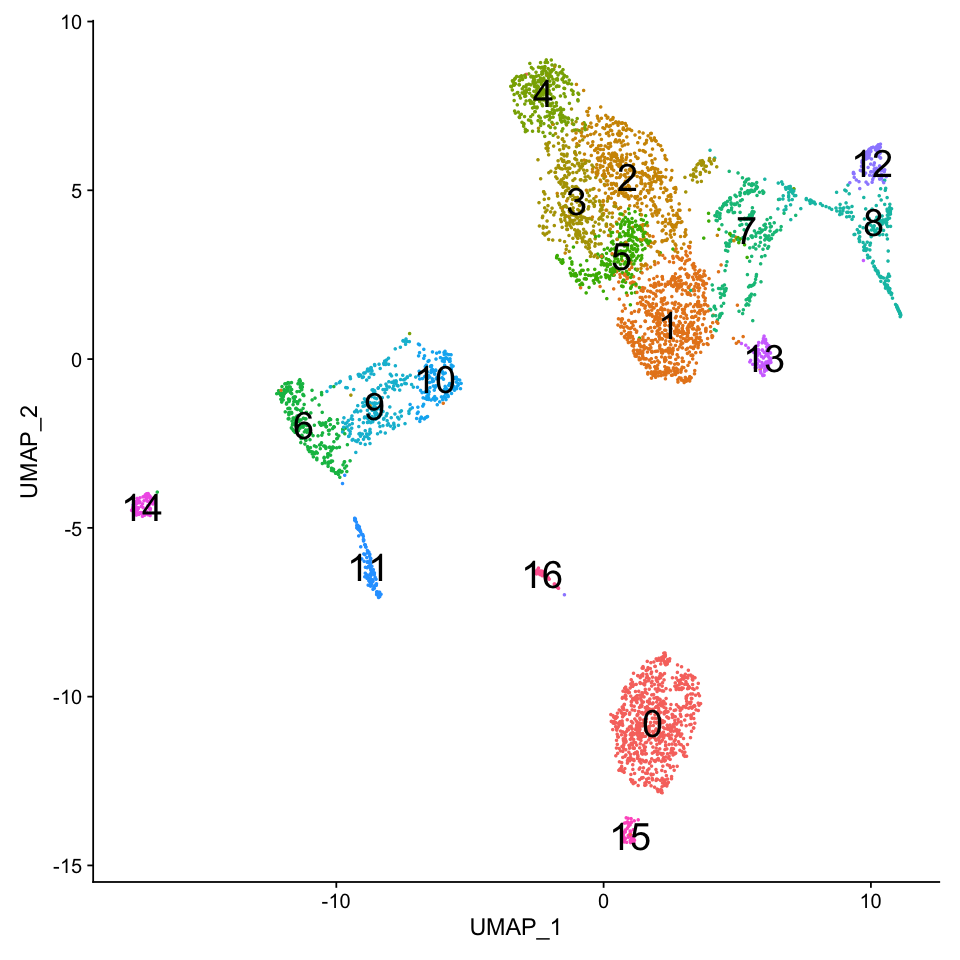

In [3]:
Idents(seu_HQC) <- 'seurat_clusters'
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(seu_HQC, reduction = 'umap', label = TRUE, label.size = 8) + NoLegend()

## Merging results

In [4]:
#loading subclustering results
seu.ecto <- readRDS(file = '../../data/seurat_object/Set2/subclustering/seu_lateral_ecto_subclustered.obj')
seu.meso <- readRDS(file = '../../data/seurat_object/Set2/subclustering/seu_meso_subclustered.obj')
seu.head <- readRDS(file = '../../data/seurat_object/Set2/subclustering/seu_head_subclustered.obj')
seu.post <- readRDS(file = '../../data/seurat_object/Set2/subclustering/seu_post_endo_subclustered.obj')
seu.ecto
seu.meso
seu.head
seu.post

An object of class Seurat 
27385 features across 2654 samples within 2 assays 
Active assay: SCT (9881 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
28364 features across 1010 samples within 2 assays 
Active assay: SCT (10860 features, 0 variable features)
 1 other assay present: RNA

An object of class Seurat 
28364 features across 357 samples within 2 assays 
Active assay: RNA (17504 features, 0 variable features)
 1 other assay present: SCT
 2 dimensional reductions calculated: pca, umap

An object of class Seurat 
25973 features across 677 samples within 2 assays 
Active assay: SCT (8469 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

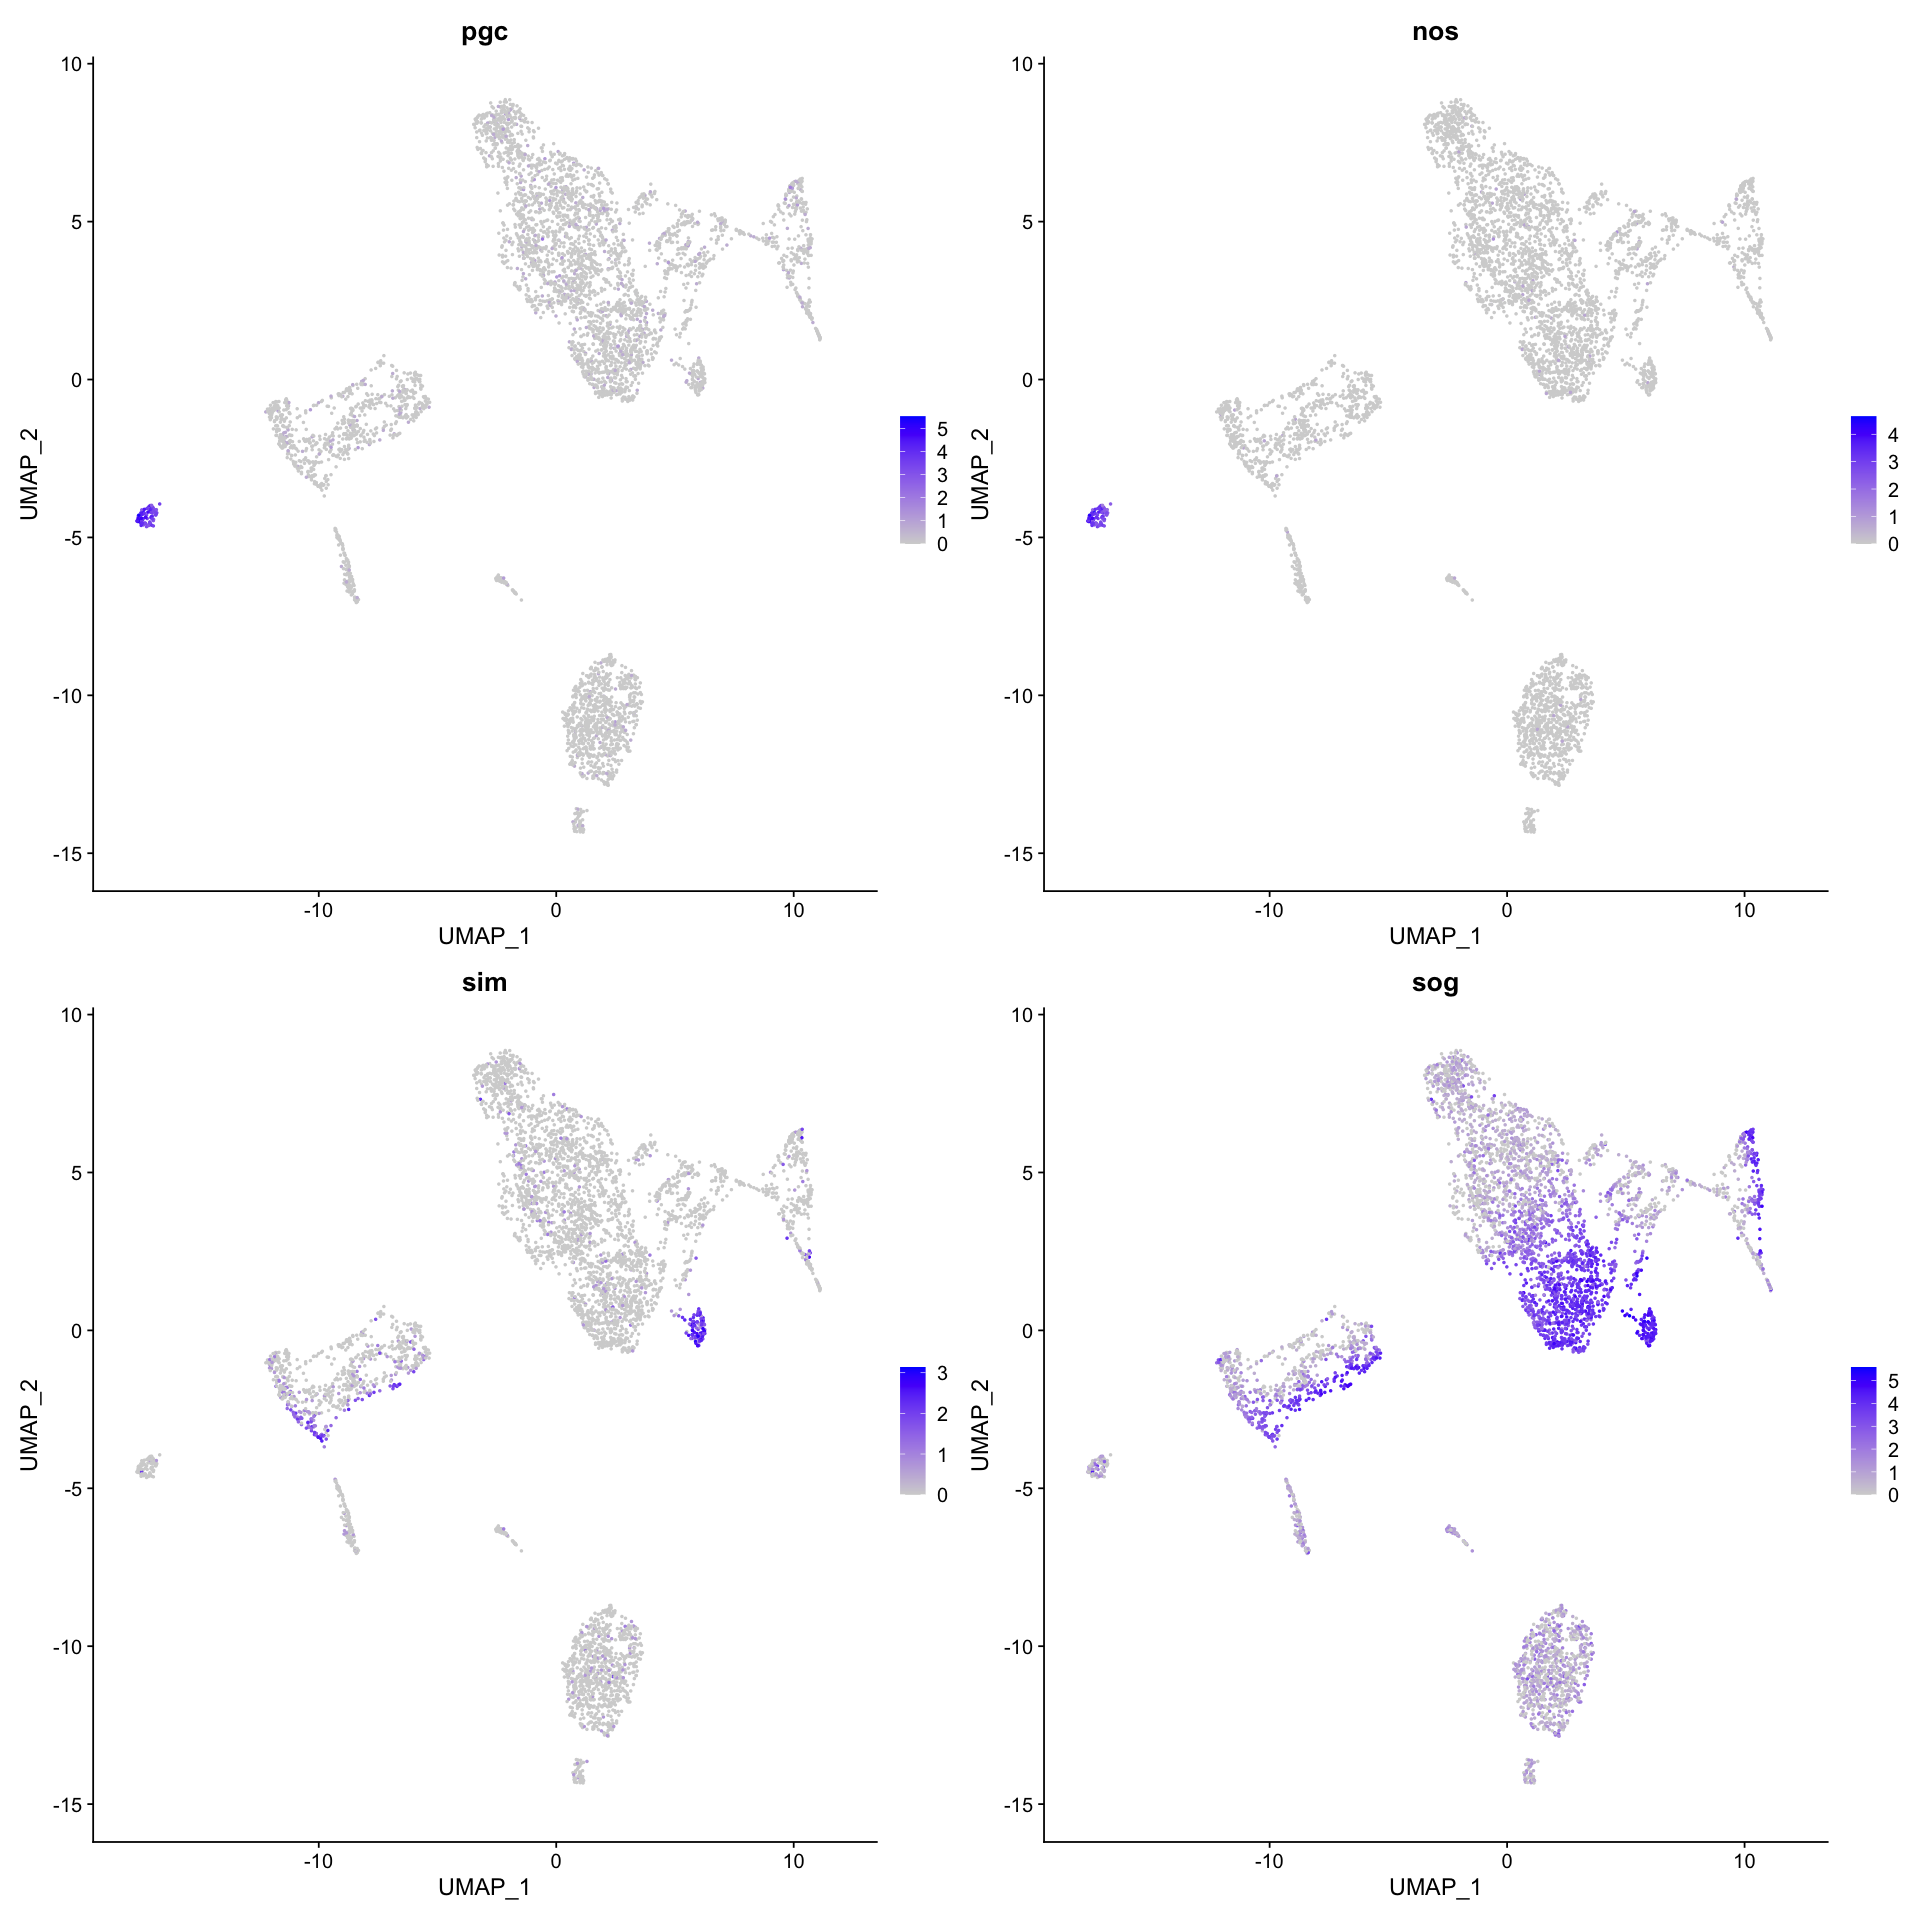

In [5]:
options(repr.plot.width=16, repr.plot.height=16)
FeaturePlot(seu_HQC, features = c('pgc','nos','sim','sog'))

In [6]:
seu.midline <- subset(seu_HQC,idents=c('13'))
seu.midline$manual_ID <- 'midline_cells'

seu.polecell <- subset(seu_HQC,idents=c('14'))
seu.polecell$manual_ID <- 'pole_cells'

In [7]:
#merge subclustering results
#subclustering results contain only singlets
seu.singlet <- merge(seu.ecto, y = c(seu.meso,seu.head,seu.post,seu.midline,seu.polecell))
seu.singlet

An object of class Seurat 
28364 features across 4877 samples within 2 assays 
Active assay: SCT (10860 features, 0 variable features)
 1 other assay present: RNA

In [8]:
singlet.list <- colnames(seu.singlet)

In [9]:
#get doublet cells list
seu.doublet <- subset(seu_HQC, cells = singlet.list, invert = TRUE)
seu.doublet

An object of class Seurat 
28364 features across 20 samples within 2 assays 
Active assay: SCT (10860 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [10]:
seu.doublet$manual_ID <- 'doublet'

## Add subclustering results into HQC dataset

In [11]:
seu.merge <- merge(seu.singlet,seu.doublet)
seu_HQC$manual_ID <- seu.merge$manual_ID

In [12]:
doublet.list <- colnames(seu.doublet)
write(doublet.list, './doublet_cells.txt')

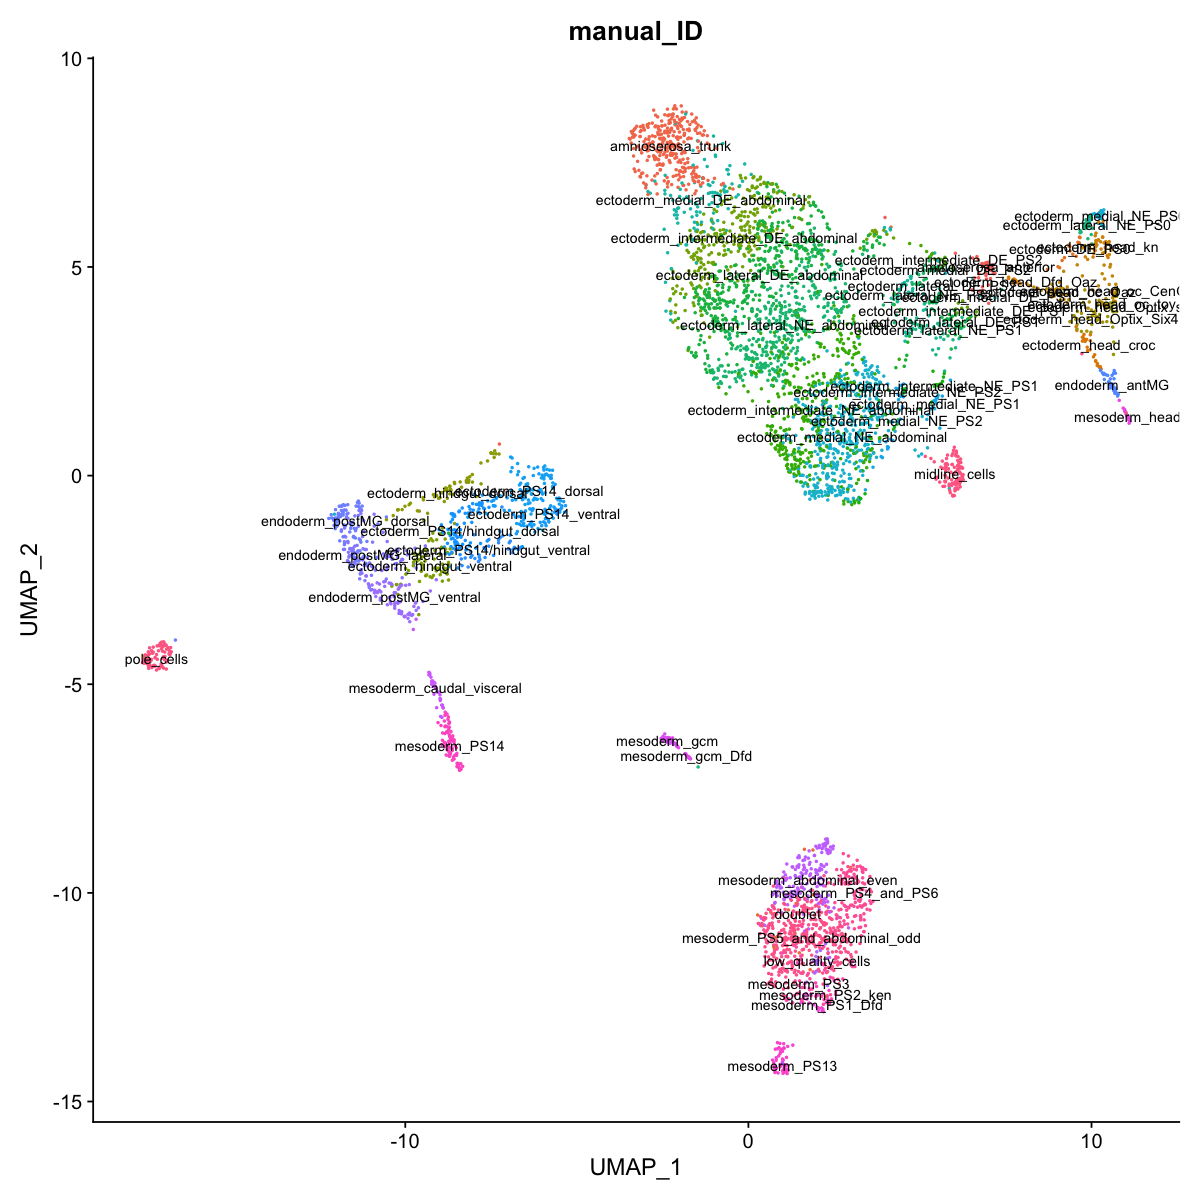

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(seu_HQC, reduction = 'umap', label.size = 3, group.by = 'manual_ID', label=T) + NoLegend()

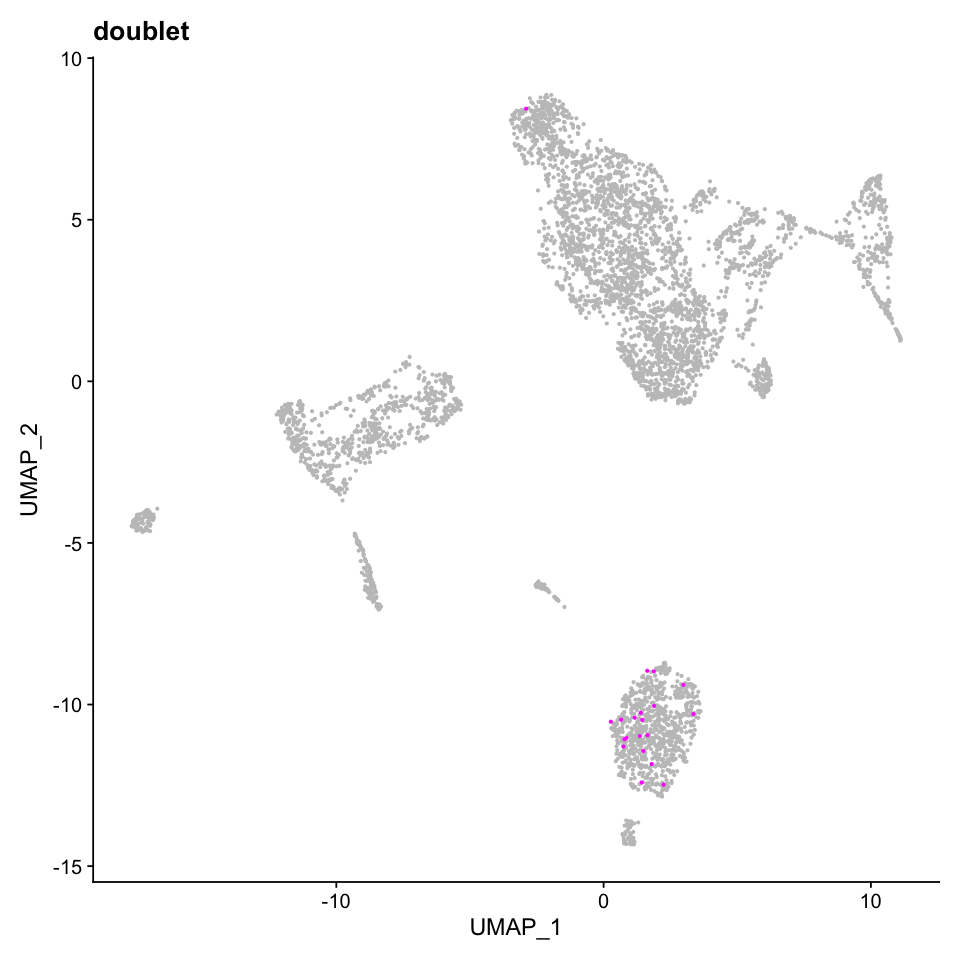

In [14]:
Idents(seu_HQC) <- 'manual_ID'
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c('doublet'))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('doublet')

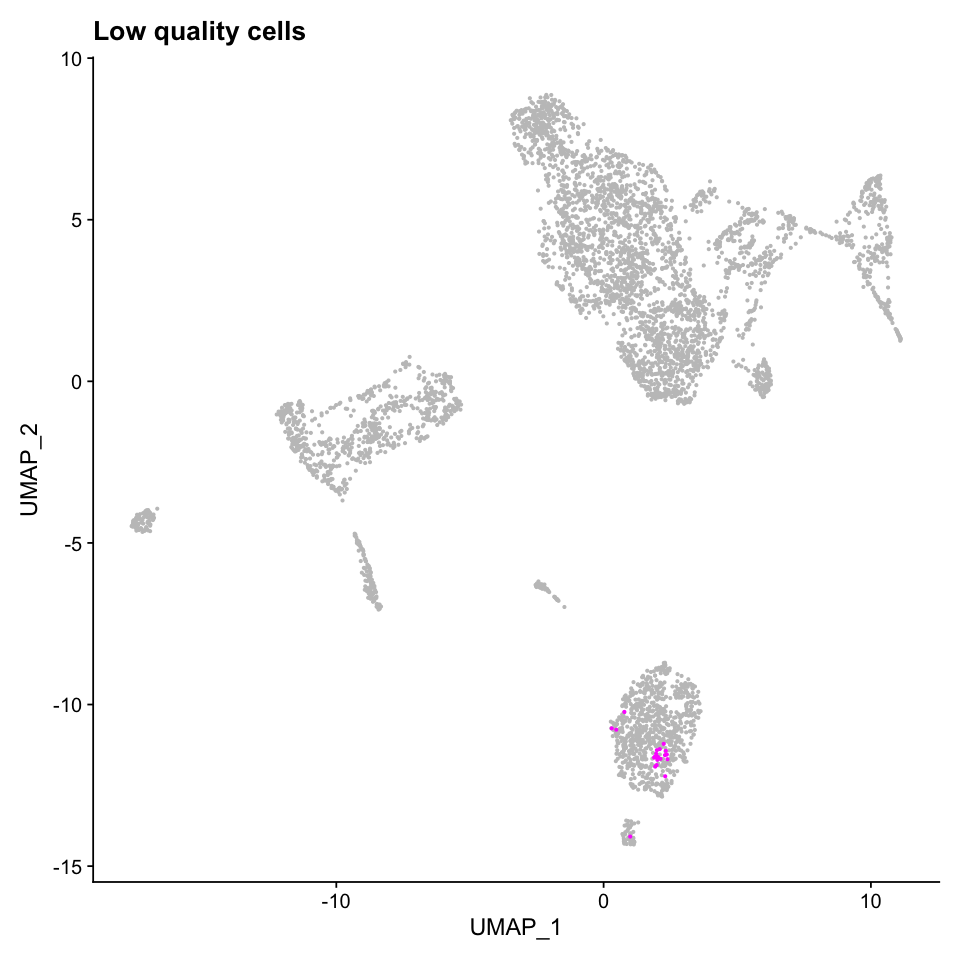

In [15]:
Idents(seu_HQC) <- 'manual_ID'
options(repr.plot.width=8, repr.plot.height=8)
highlight.cells <- WhichCells(seu_HQC,idents = c('low_quality_cells'))
DimPlot(seu_HQC, reduction =  "umap", cells.highlight = highlight.cells, pt.size = 0.5, sizes.highlight = 0.5,
        cols.highlight = 'magenta', label = FALSE) + NoLegend() + ggtitle('Low quality cells')

In [16]:
write.table(as.data.frame(seu_HQC$manual_ID), sep='\t', file='./manual_ID.txt', col.names=FALSE)

## Removing doublets and low-quality cells for downstream analysis

In [17]:
Idents(seu.singlet) <- 'manual_ID'
seu.non.stressed <- subset(seu_HQC, ident=c('low_quality_cells', 'doublet'),invert=T)
seu.non.stressed

An object of class Seurat 
28364 features across 4855 samples within 2 assays 
Active assay: SCT (10860 features, 3000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

## Re-normalize without doublet and low-quality cells

In [18]:
DefaultAssay(seu.non.stressed) <- 'RNA'
seu.non.stressed <- suppressWarnings(SCTransform(seu.non.stressed, vars.to.regress = c('percent.mt','percent.rRNA')))

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 10851 by 4855

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4855 cells



  |======================================================================| 100%


Found 146 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 10851 genes



  |======================================================================| 100%


Computing corrected count matrix for 10851 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 51.02953 secs

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, percent.rRNA

Centering data matrix

Set default assay to SCT



PC_ 1 
Positive:  twi, sna, CadN, hll, Ilp4, zfh1, Act87E, sprt, Cyp310a1, Mef2 
	   Mes2, CG12177, htl, tin, stumps, CG16758, NetA, VepD, shep, CG14688 
	   NetB, Mdr49, CG3036, lncRNA:CR45361, CG11357, CG1673, Nplp2, ltl, CG43658, CG43355-sala 
Negative:  SoxN, ImpL2, Brd, ths, sog, E(spl)m4-BFM, Lac, E(spl)mgamma-HLH, CG13427, E(spl)malpha-BFM 
	   Dl, Tet, cv-2, aop, CG15628, sca, hth, Tom, blot, toc 
	   CG34224, ASPP, CG13217, BobA, CG10035, mirr, tup, grh, E(spl)m7-HLH, 5-HT2A 
PC_ 2 
Positive:  SoxN, sog, ths, sca, ImpL2, D, Tet, Toll-6, E(spl)mgamma-HLH, Meltrin 
	   brk, Tollo, Cys, gsb, Dl, slp1, esg, wb, pyr, sad 
	   Dr, Obp99a, Pino, l(1)sc, CG17724-Kdm4B-seq, ind, rdx, path, Hsp83, ac 
Negative:  mirr, tup, peb, CG45263, egr, Ance, cv-2, srp, Dtg, Ama 
	   Doc1, hbs, dap, ush, Svil, Alk, Doc3, Z600, CG14427, emc 
	   kay, prage, C15, rst, pnr, sas, Doc2, CG42342, scyl, CrebA 
PC_ 3 
Positive:  pgc, nos, stai, bru1, del, wisp, Tao, cib, ovo, BigH1 
	   Eno, Hsp27, shu, Hs

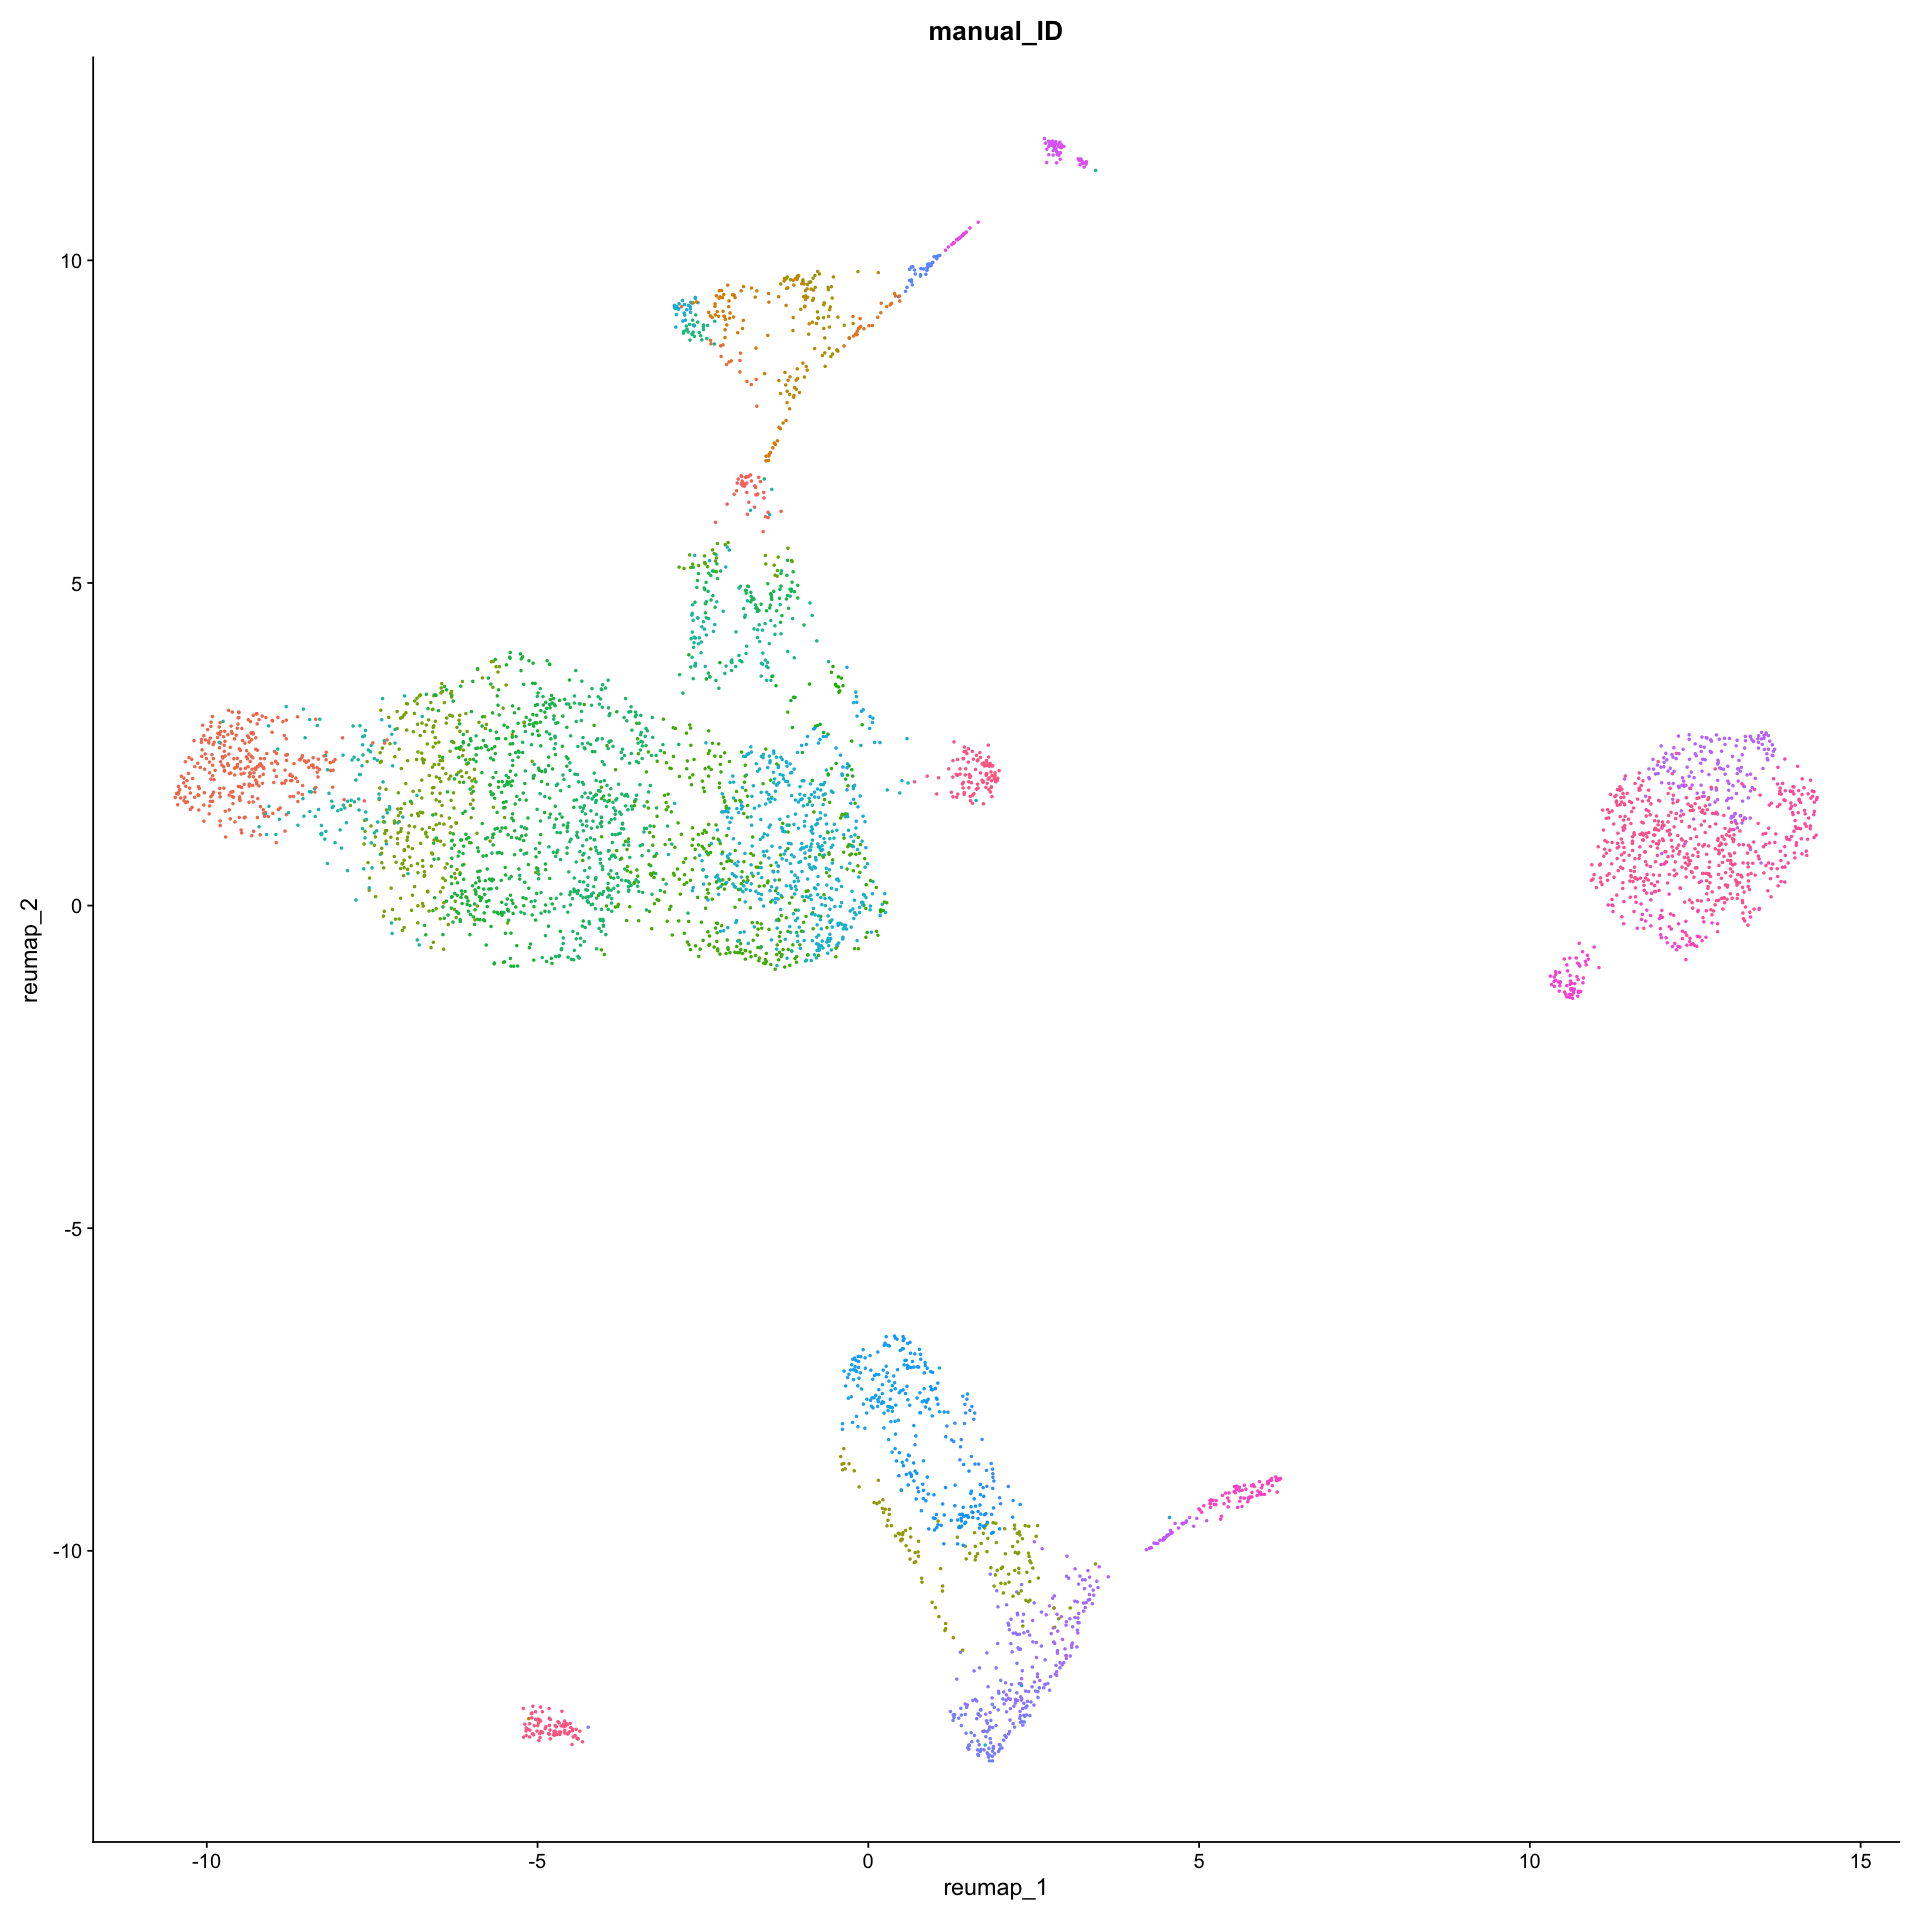

In [19]:
seu.non.stressed <- RunPCA(seu.non.stressed)
seu.non.stressed <- RunUMAP(seu.non.stressed, dims=1:30, reduction.name = 'reumap')
options(repr.plot.width=16, repr.plot.height=16)
DimPlot(seu.non.stressed, reduction = 'reumap', label.size = 8, group.by = 'manual_ID') + NoLegend()

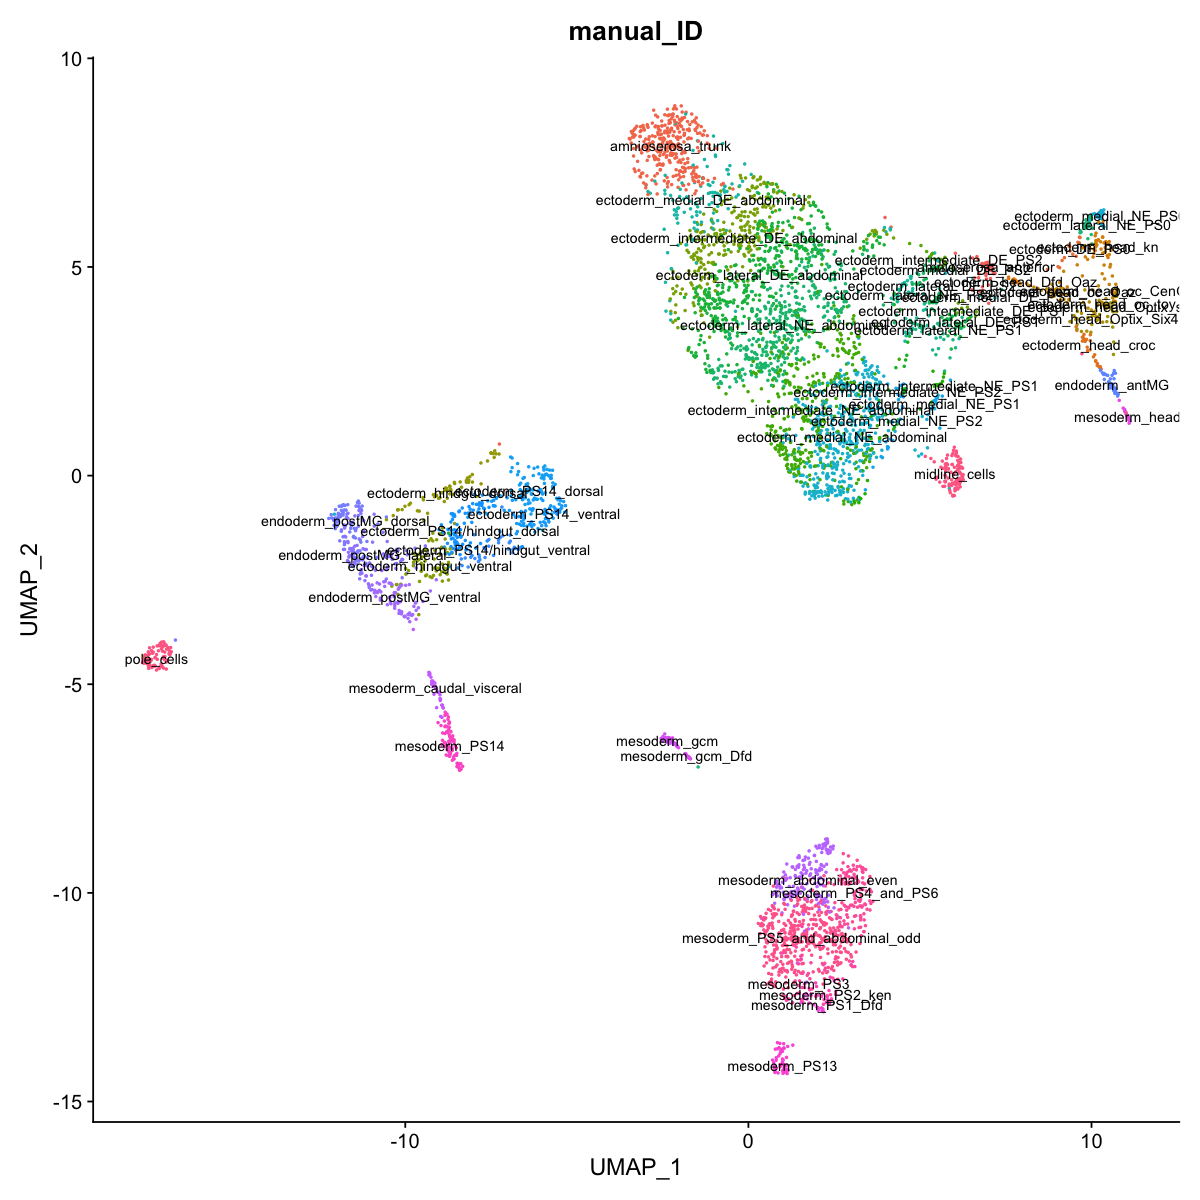

In [20]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(seu.non.stressed, reduction = 'umap', label.size = 3, group.by = 'manual_ID', label=T) + NoLegend()

In [21]:
levels <- read.table(file="./manual_ID_levels_color_Set2.txt", ,comment.char = "")
colors <- levels[,2]
levels <- levels[,1]
head(levels)
length(levels)
head(colors)
setdiff(seu.non.stressed$manual_ID, levels)
levels(seu.non.stressed) <- levels

[1] "ectoderm_head_croc"       "ectoderm_head_Optix_Six4"
[3] "ectoderm_head_Optix_sog"  "ectoderm_head_oc_toy"    
[5] "ectoderm_head_oc_CenG1A"  "ectoderm_head_oc_Oaz"

[1] 55

[1] "lightsteelblue1" "lightsteelblue2" "lightsteelblue3" "lightskyblue1"  
[5] "lightskyblue3"   "skyblue1"

character(0)

Saving 7 x 7 in image



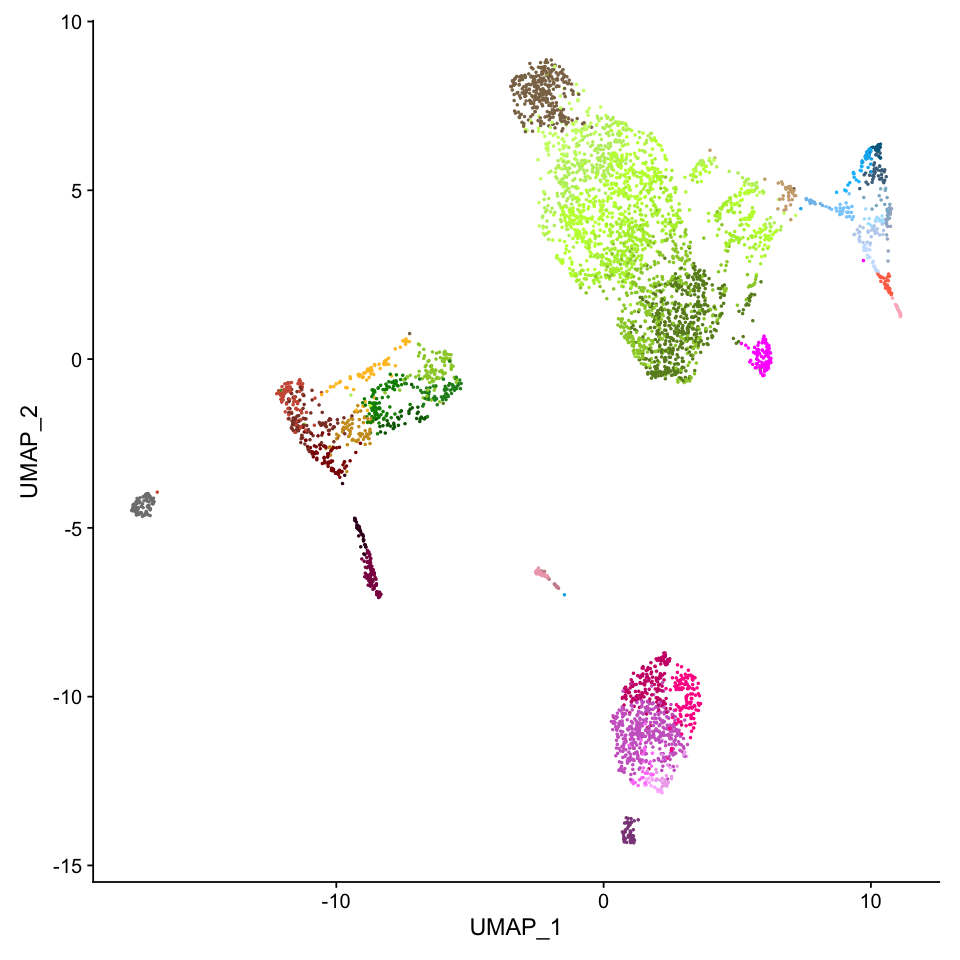

In [22]:
options(repr.plot.width=8, repr.plot.height=8)
fig <- DimPlot(seu.non.stressed, reduction =  "umap", label = FALSE, cols = colors) + NoLegend() 
fig
ggsave(fig, file = "./figures/08_merge_ID/all_cells_umap_Set2.eps", dpi = 300)

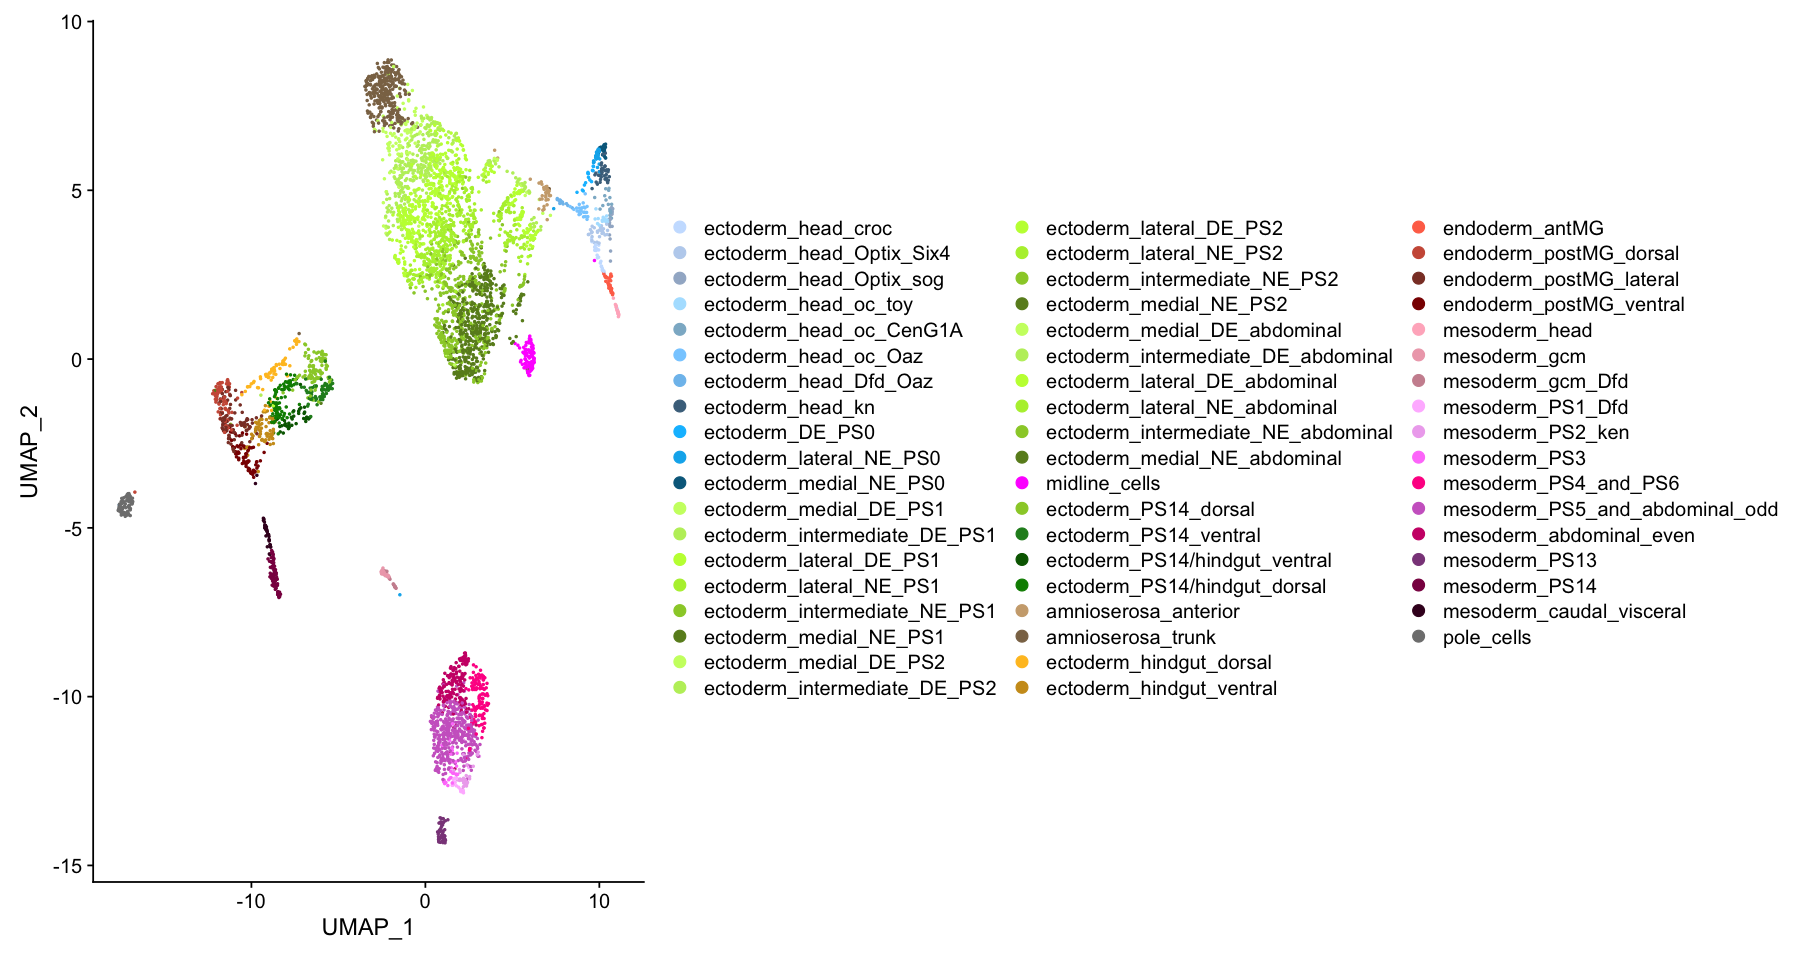

In [23]:
options(repr.plot.width=15, repr.plot.height=8)
fig <- DimPlot(seu.non.stressed, reduction =  "umap", label = FALSE, cols = colors)
fig
ggsave(fig, file = "./figures/08_merge_ID/all_cells_umap2_Set2.eps", dpi = 300, width = 20, height = 8)

## Preparing conversion to loom file

In [24]:
manual_ID <- seu.non.stressed$manual_ID
unique.manual_ID <- unique(manual_ID)
manual_ID_num <- copy(manual_ID)
i <- 1
for (name in unique.manual_ID){
    rname <- paste('^',name, sep = '')
    rname <- paste(rname, '$', sep = '')
    manual_ID_num <- gsub(manual_ID_num, pattern = rname, replacement = i)
    i <- i + 1
}
seu.non.stressed$manual_ID_num <- manual_ID_num

In [25]:
Idents(seu.non.stressed) <- 'manual_ID'
annot_df <- data.frame(list(
    cluster_id = 1:length(unique.manual_ID), 
    cluster_name = unique.manual_ID))
annot_df

cluster_id,cluster_name
<int>,<chr>
1,ectoderm_head_oc_CenG1A
2,ectoderm_hindgut_dorsal
3,ectoderm_intermediate_NE_abdominal
4,amnioserosa_trunk
5,ectoderm_intermediate_DE_abdominal
6,ectoderm_lateral_NE_abdominal
7,endoderm_postMG_ventral
8,ectoderm_medial_DE_abdominal
9,ectoderm_lateral_DE_PS2


In [26]:
write.csv(annot_df, file = './annot_df.csv')

In [27]:
saveRDS(object = seu_HQC, file = '../../data/seurat_object/Set2/seu_HQC_subclusterd_Set2.obj')

In [28]:
saveRDS(object = seu.non.stressed, file = '../../data/seurat_object/Set2/seu_HQC_subclusterd2_Set2.obj')

In [29]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] ja_JP.UTF-8/ja_JP.UTF-8/ja_JP.UTF-8/C/ja_JP.UTF-8/ja_JP.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] tibble_3.0.5      dplyr_1.0.3       Matrix_1.3-2      data.table_1.13.6
[5] magrittr_2.0.1    ggplot2_3.3.3     Seurat_3.2.3     

loaded via a namespace (and not attached):
  [1] nlme_3.1-151          matrixStats_0.57.0    RcppAnnoy_0.0.18     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.3.2     tools_4.0.3           R6_2.5.1             
 [10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-18   
 [13] uwot_0.1.10           mgcv